In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [ ]:
# Imports here
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets, models, transforms

from PIL import Image
from operator import itemgetter

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [ ]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [ ]:
new_size = (224,224)
# TODO: Define your transforms for the training, validation, and testing sets
train_data_transforms = transforms.Compose([transforms.Resize(size=new_size),
                                            transforms.RandomRotation(30),
                                            transforms.RandomHorizontalFlip(0.5),
                                            transforms.RandomVerticalFlip(0.5),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406],
                                                                 [0.229, 0.224, 0.225])]) 
other_data_transforms = transforms.Compose([transforms.Resize(size=new_size),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder(train_dir, train_data_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, other_data_transforms)
test_dataset  = datasets.ImageFolder(test_dir, other_data_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=32)

##### Data Information

In [ ]:
print(f"Train Dataset Size = {len(train_loader.dataset)}")
print(f"Valid Dataset Size = {len(valid_loader.dataset)}")
print(f"Test  Dataset Size = {len(test_loader.dataset)}")

Train Dataset Size = 6552
Valid Dataset Size = 818
Test  Dataset Size = 819


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [ ]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

#### Check Cuda

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#### Build The Model (Transfer Leanring)

In [ ]:
model = models.resnet18(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
num_classes = 102
new_classifier = nn.Sequential(*[nn.Linear(512, num_classes)])

model.fc = new_classifier
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Loss Function & Optimizer


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#### Training and Validation Routines
**NOTE: THE TRAINING, VALIDATION, AND TESTING ROUTINES WERE TAKING FROM MY GITHUB REPOSITORY (https://github.com/mogh99/ML-DL_GeneralCodes) WHICH BASED ON THE DEEP LEARNING NANO DEGREE THAT I AM TAKING CURRENTLY**

In [ ]:
n_epochs = 10
model.to(device)
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    train_correct = 0
    valid_correct = 0

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move to GPU
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # sum all the correct predictions to find the training accuracy
        _, predicted_labels = output.max(1)
        train_correct += (predicted_labels == target).sum().cpu().numpy()
        # update running training loss
        train_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
        # print updates every 10 batches
        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch: {epoch} \tBatch Index: {batch_idx+1} \tTraining Loss: {train_loss}")

    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move to GPU
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # sum all the correct predictions to find the validation accuracy
        _, predicted_labels = output.max(1)
        valid_correct += (predicted_labels == target).sum().cpu().numpy()
        # update running validation loss 
        valid_loss += (loss.data.item() - valid_loss) / (batch_idx + 1)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f}% \tValidation Loss: {:.6f} \tValidation Accuracy {:.6f}%'.format(
        epoch,
        train_loss,
        (train_correct/len(train_dataset))*100,
        valid_loss,
        (valid_correct/len(valid_dataset))*100
        ))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Batch Index: 10 	Training Loss: 4.8802896499633786
Epoch: 1 	Batch Index: 20 	Training Loss: 4.730307054519653
Epoch: 1 	Batch Index: 30 	Training Loss: 4.582343904177347
Epoch: 1 	Batch Index: 40 	Training Loss: 4.450129574537277
Epoch: 1 	Batch Index: 50 	Training Loss: 4.332402005195617
Epoch: 1 	Batch Index: 60 	Training Loss: 4.204259705543518
Epoch: 1 	Batch Index: 70 	Training Loss: 4.0981987271990095
Epoch: 1 	Batch Index: 80 	Training Loss: 4.001383763551711
Epoch: 1 	Batch Index: 90 	Training Loss: 3.883615912331475
Epoch: 1 	Batch Index: 100 	Training Loss: 3.7904556012153625
Epoch: 1 	Batch Index: 110 	Training Loss: 3.7018941207365557
Epoch: 1 	Batch Index: 120 	Training Loss: 3.617484931151072
Epoch: 1 	Batch Index: 130 	Training Loss: 3.53103575523083
Epoch: 1 	Batch Index: 140 	Training Loss: 3.450228067806789
Epoch: 1 	Batch Index: 150 	Training Loss: 3.374980479876201
Epoch: 1 	Batch Index: 160 	Training Loss: 3.3036482661962507
Epoch: 1 	Batch Index: 170 	T

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [ ]:
# monitor test loss and accuracy
test_loss = 0.
correct = 0.
total = 0.

# set the module to evaluation mode
model.eval()
model.to(device)
for batch_idx, (data, target) in enumerate(test_loader):
    # move to GPU
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update average test loss 
    test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
    # convert output probabilities to predicted class
    _, pred = output.max(1)
    # compare predictions to true label
    correct += (pred == target).sum().cpu().numpy()
    total += data.size(0)
        
print('Test Loss: {:.6f}\n'.format(test_loss))

print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
    100. * correct / total, correct, total))

Test Loss: 0.627418


Test Accuracy: 83% (682/819)


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [ ]:
checkpoint_path = "model_checkpoint.pth"

In [ ]:
# TODO: Save the checkpoint 
checkpoint = {
    "state_dict": model.state_dict(),
    "model": models.resnet18(pretrained=True),
    "attribute_to_change": "fc",
    "new_attribute": model.fc,
    "class_to_idx": train_dataset.class_to_idx,
}

torch.save(checkpoint, checkpoint_path)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [ ]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
checkpoint = torch.load(checkpoint_path)
model = checkpoint["model"]
setattr(model, checkpoint["attribute_to_change"], checkpoint["new_attribute"])

model.class_to_idx = checkpoint["class_to_idx"]

model.load_state_dict(checkpoint["state_dict"])
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [ ]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    img = Image.open(image)
    data_transforms = transforms.Compose([transforms.Resize(size=(224,224)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                              [0.229, 0.224, 0.225])])
    
    img = data_transforms(img)

    return img

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [ ]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [ ]:
!

 assets				      predict.py
 cat_to_name.json		      README.md
 flower_data.tar.gz		      TestImage1_Class87.jpg
 flowers			      TestImage2_Class34.jpg
'Image Classifier Project.ipynb'      TestImage3_Class17.jpg
'Image Classifier Project-zh.ipynb'   TestImage4_Class95.jpg
 LICENSE			      train.py
 model_checkpoint.pth


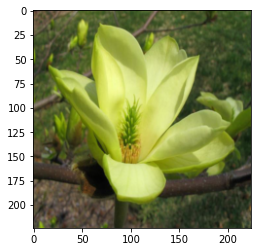

In [ ]:
image = process_image("/content/drive/MyDrive/Udacity/ML-IntroductionWithPyTorch/Project02-ImageClassifier/p2_image_classifier/TestImage1_Class87.jpg")
imshow(image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [ ]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    img = process_image(image_path)
    imshow(img)
    img = img.unsqueeze(0).to(device)

    model.eval()
    model.to(device)

    output = model(img)

    prob = nn.functional.softmax(output, dim=1)
    top_p, top_class = prob.topk(topk, dim=1)
    
    top_p, top_class = top_p.detach().cpu().numpy()[0], top_class.cpu().numpy()[0]
    
    fliped_idxes = {value: key for key, value in model.class_to_idx.items()}
    
    top_class_names = [cat_to_name[fliped_idxes[idx]] for idx in top_class]

    fig = plt.figure(figsize=(10,5))
    plt.bar(top_class_names, top_p, color="green")
    plt.xlabel("Class_Name")
    plt.ylabel("Class_Probability")
    plt.title(f"Top-{topk} Class Probabilities")
    plt.show

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


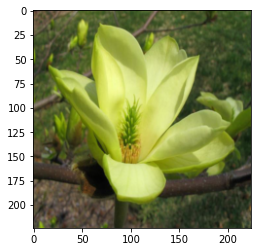

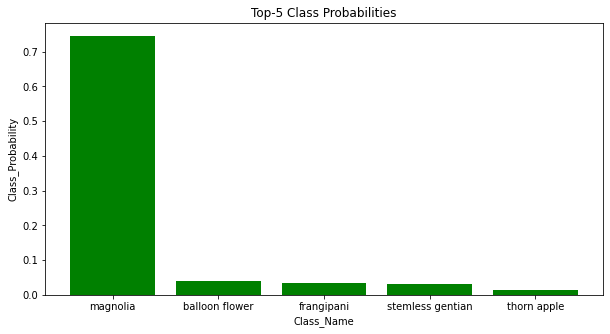

In [ ]:
predict("/content/drive/MyDrive/Udacity/ML-IntroductionWithPyTorch/Project02-ImageClassifier/p2_image_classifier/TestImage1_Class87.jpg", model, 5)

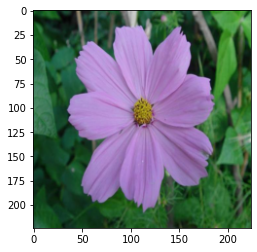

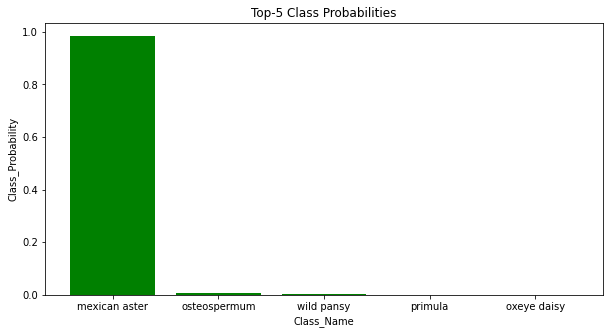

In [ ]:
predict("/content/drive/MyDrive/Udacity/ML-IntroductionWithPyTorch/Project02-ImageClassifier/p2_image_classifier/TestImage2_Class34.jpg", model, 5)

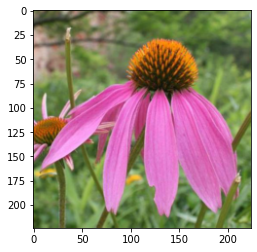

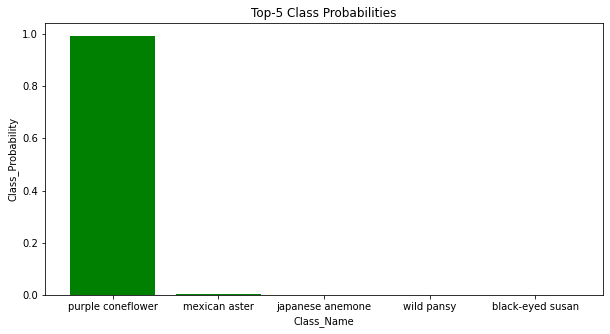

In [ ]:
predict("/content/drive/MyDrive/Udacity/ML-IntroductionWithPyTorch/Project02-ImageClassifier/p2_image_classifier/TestImage3_Class17.jpg", model, 5)

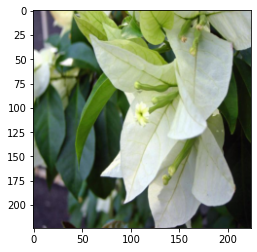

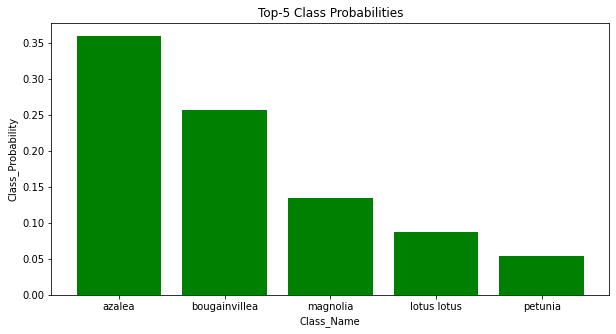

In [ ]:
predict("/content/drive/MyDrive/Udacity/ML-IntroductionWithPyTorch/Project02-ImageClassifier/p2_image_classifier/TestImage4_Class95.jpg", model, 5)